In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

data = pd.read_excel("data_lexp.xlsx")
#Due to the fact that there are a lot of empties in 2023 I am deciding to drop this year
data = data.rename(columns={"Atrybut" : "Year"})
data = data[data['Year'] != 2023]

Exploratory data analysis

In [59]:
data.head(5)

,Country Name,Country Code,Year,"Life expectancy at birth, total (years)",Population growth (annual %),"Population, total",Access to electricity (% of population),GDP per capita (current US$),Current health expenditure (% of GDP)
0,Afghanistan,AFG,2000,55.005,1.212176,20130327,4.4,174.930991,..
1,Afghanistan,AFG,2001,55.511,0.762005,20284307,9.3,138.706822,..
2,Afghanistan,AFG,2002,56.225,5.25203,21378117,14.1,178.954088,9.443391
3,Afghanistan,AFG,2003,57.171,6.145194,22733049,19,198.871116,8.941258
4,Afghanistan,AFG,2004,57.810,3.575835,23560654,23.8,221.763654,9.808474


In [60]:
data_2022 = data[data["Year"] == 2022]
data_2022.head(5)

,Country Name,Country Code,Year,"Life expectancy at birth, total (years)",Population growth (annual %),"Population, total",Access to electricity (% of population),GDP per capita (current US$),Current health expenditure (% of GDP)
22,Afghanistan,AFG,2022,65.617000,1.435704,40578842,85.3,357.261153,23.088169
46,Africa Eastern and Southern,AFE,2022,64.487020,2.592754,731821393,48.801258,1628.318944,5.72792
70,Africa Western and Central,AFW,2022,57.987813,2.33227,497387180,55.686683,1796.668633,4.209822
94,Albania,ALB,2022,78.769000,-1.21579,2777689,100,6846.426694,6.193681
118,Algeria,DZA,2022,76.129000,1.587582,45477389,100,4961.552577,3.623043


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5382 entries, 0 to 5614
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country Name                             5382 non-null   object 
 1   Country Code                             5382 non-null   object 
 2   Year                                     5382 non-null   int64  
 3   Life expectancy at birth, total (years)  5382 non-null   float64
 4   Population growth (annual %)             5382 non-null   object 
 5   Population, total                        5382 non-null   int64  
 6   Access to electricity (% of population)  5382 non-null   object 
 7   GDP per capita (current US$)             5382 non-null   object 
 8   Current health expenditure (% of GDP)    5382 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 420.5+ KB


Handling missing data by dropping countries with the least info. 

In [8]:
(data == "..").sum()

Country Name                                 0
Country Code                                 0
Year                                         0
Life expectancy at birth, total (years)      0
Population growth (annual %)                 1
Population, total                            0
Access to electricity (% of population)     71
GDP per capita (current US$)               161
Current health expenditure (% of GDP)      653
dtype: int64

In [114]:
data['empty_values'] = (data == "..").sum(axis=1)
countries_to_delete = data.groupby("Country Name")["empty_values"].sum().sort_values(ascending =False)[0:32].index.to_numpy()
data = data[~data["Country Name"].isin(countries_to_delete)]
(data == "..").sum()

Country Name                               0
Country Code                               0
Year                                       0
Life expectancy at birth, total (years)    0
Population growth (annual %)               1
Population, total                          0
Access to electricity (% of population)    2
GDP per capita (current US$)               6
Current health expenditure (% of GDP)      9
empty_values                               0
dtype: int64

In [115]:
#Current health expenditure (% of GDP) missing data
#handling Afghanistan, Iraq, Timor-Leste
for country in ["Afghanistan", "Iraq", "Timor-Leste"]:
    temp = data[data["Country Name"] == country]["Current health expenditure (% of GDP)"][3:6].mean()
    arr = data[data["Country Name"] == country]["Current health expenditure (% of GDP)"].replace("..",temp)
    data.loc[data["Country Name"] == country,"Current health expenditure (% of GDP)"] = arr
#handling Ukraine
temp = data[data["Country Name"] == "Ukraine"]["Current health expenditure (% of GDP)"][-2:-1].mean()
arr = data[data["Country Name"] == "Ukraine"]["Current health expenditure (% of GDP)"].replace("..",temp)
data.loc[data["Country Name"] == "Ukraine","Current health expenditure (% of GDP)"] = arr

#GDP per capita (current US$) missing data
for country in ["Cuba", "Yemen, Rep."]:
    temp = data[data["Country Name"] == country]["GDP per capita (current US$)"][-5:-4].mean()
    arr = data[data["Country Name"] == country]["GDP per capita (current US$)"].replace("..",temp)
    data.loc[data["Country Name"] == country,"GDP per capita (current US$)"] = arr

#Access to electricity (% of population) missing data
temp = data[data["Country Name"] == "Guinea-Bissauy"]["Access to electricity (% of population)"][2:3].mean()
arr = data[data["Country Name"] == "Guinea-Bissau"]["Access to electricity (% of population)"].replace("..",temp)
data.loc[data["Country Name"] == "Guinea-Bissau","Access to electricity (% of population)"] = arr


values = data[data["Country Name"] == "Seychelles"]["Population, total"].to_numpy()
temp = ((values[-1] - values[-2])/values[-1] * 100)
arr = data[data["Country Name"] == "Seychelles"]["Population growth (annual %)"].replace("..",temp)
data.loc[data["Country Name"] == "Seychelles","Population growth (annual %)"] = arr

C:\Users\Maksym\AppData\Local\Temp\ipykernel_11192\1478407007.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arr = data[data["Country Name"] == country]["Current health expenditure (% of GDP)"].replace("..",temp)
C:\Users\Maksym\AppData\Local\Temp\ipykernel_11192\1478407007.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arr = data[data["Country Name"] == country]["Current health expenditure (% of GDP)"].replace("..",temp)
C:\Users\Maksym\AppData\Local\Temp\ipykernel_11192\1478407007.py:5: FutureWarning: Downcasting behav

Charts

In [11]:
countries = ["China", "India","European Union", "United States", "Indonesia", "Pakistan", "Nigeria", "Brazil", "Bangladesh", "Russian Federation", "Mexico", "Switzerland", "Afghanistan"]
data_to_vis = data[data["Country Name"].isin(countries)]
data_2022 = data[data["Year"] == 2022]
regions = ["World","Early-demographic dividend","Lower middle income","East Asia & Pacific","Late-demographic dividend","South Asia","Sub-Saharan Africa", "Europe & Central Asia",
           "Middle East, North Africa, Afghanistan & Pakistan","Africa Eastern and Southern","Africa Western and Central","Arab World", "Euro area",
           "European Union","Latin America & the Caribbean (IDA & IBRD countries)", "North America"]
data_2022 = data_2022[~data_2022["Country Name"].isin(regions)]

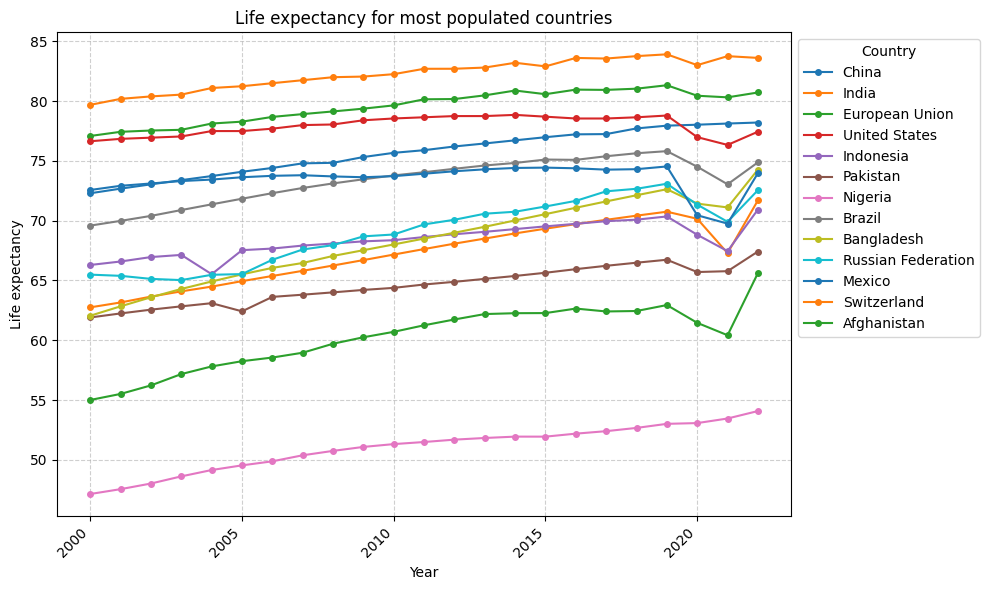

In [12]:
plt.figure(figsize=(10, 6))

for country in countries:
    df_country = data_to_vis[data_to_vis['Country Name'] == country]
    plt.plot(df_country['Year'], df_country['Life expectancy at birth, total (years)'], label=country, marker='o', markersize=4)

plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.title('Life expectancy for most populated countries')
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(data_to_vis['Year'].unique()[::5], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

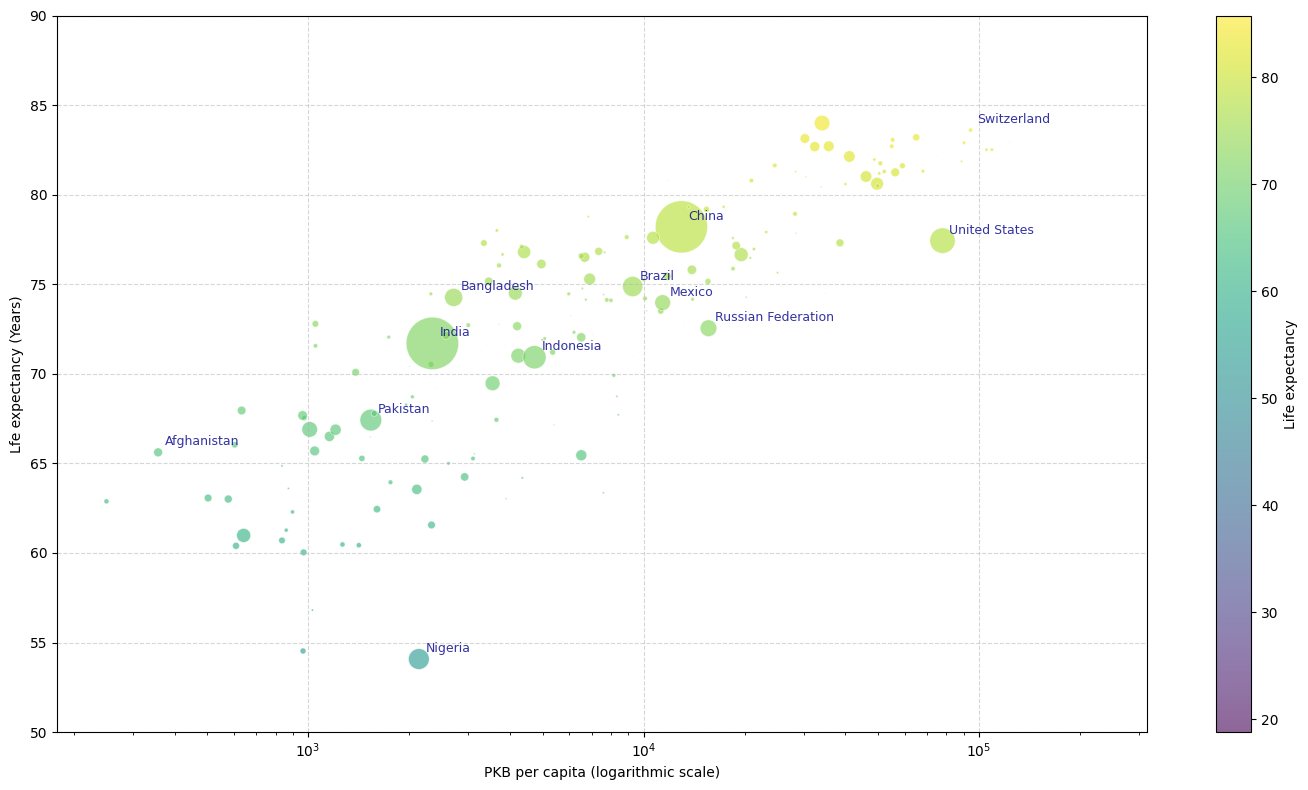

In [13]:
bubble_scale = 1000000 
point_size = data_2022['Population, total'] / bubble_scale

plt.figure(figsize=(18, 8))

plt.xscale('log')
scatter = plt.scatter(
    x = data_2022['GDP per capita (current US$)'], 
    y = data_2022['Life expectancy at birth, total (years)'], 
    s = point_size,  
    alpha=0.6,        
    c=data_2022['Life expectancy at birth, total (years)'], 
    cmap='viridis',   
    edgecolors='w',     
    linewidth=0.5
)

for i, row in data_2022[data_2022["Country Name"].isin(countries)].iterrows():
    x_coord = row['GDP per capita (current US$)']
    y_coord = row['Life expectancy at birth, total (years)']
    country_label = row['Country Name'] 
    plt.annotate(country_label, 
                 (x_coord, y_coord),
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9,    
                 alpha=0.8,
                 color = "darkblue")

plt.xlabel('PKB per capita (logarithmic scale)')
plt.ylabel('Lfe expectancy (Years)')
plt.ylim(50,90)

cbar = plt.colorbar(scatter)
cbar.set_label('Life expectancy')


plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

We can see the strong linearity between the log of PKB per capita and life expectancy

Let's see feature distributions

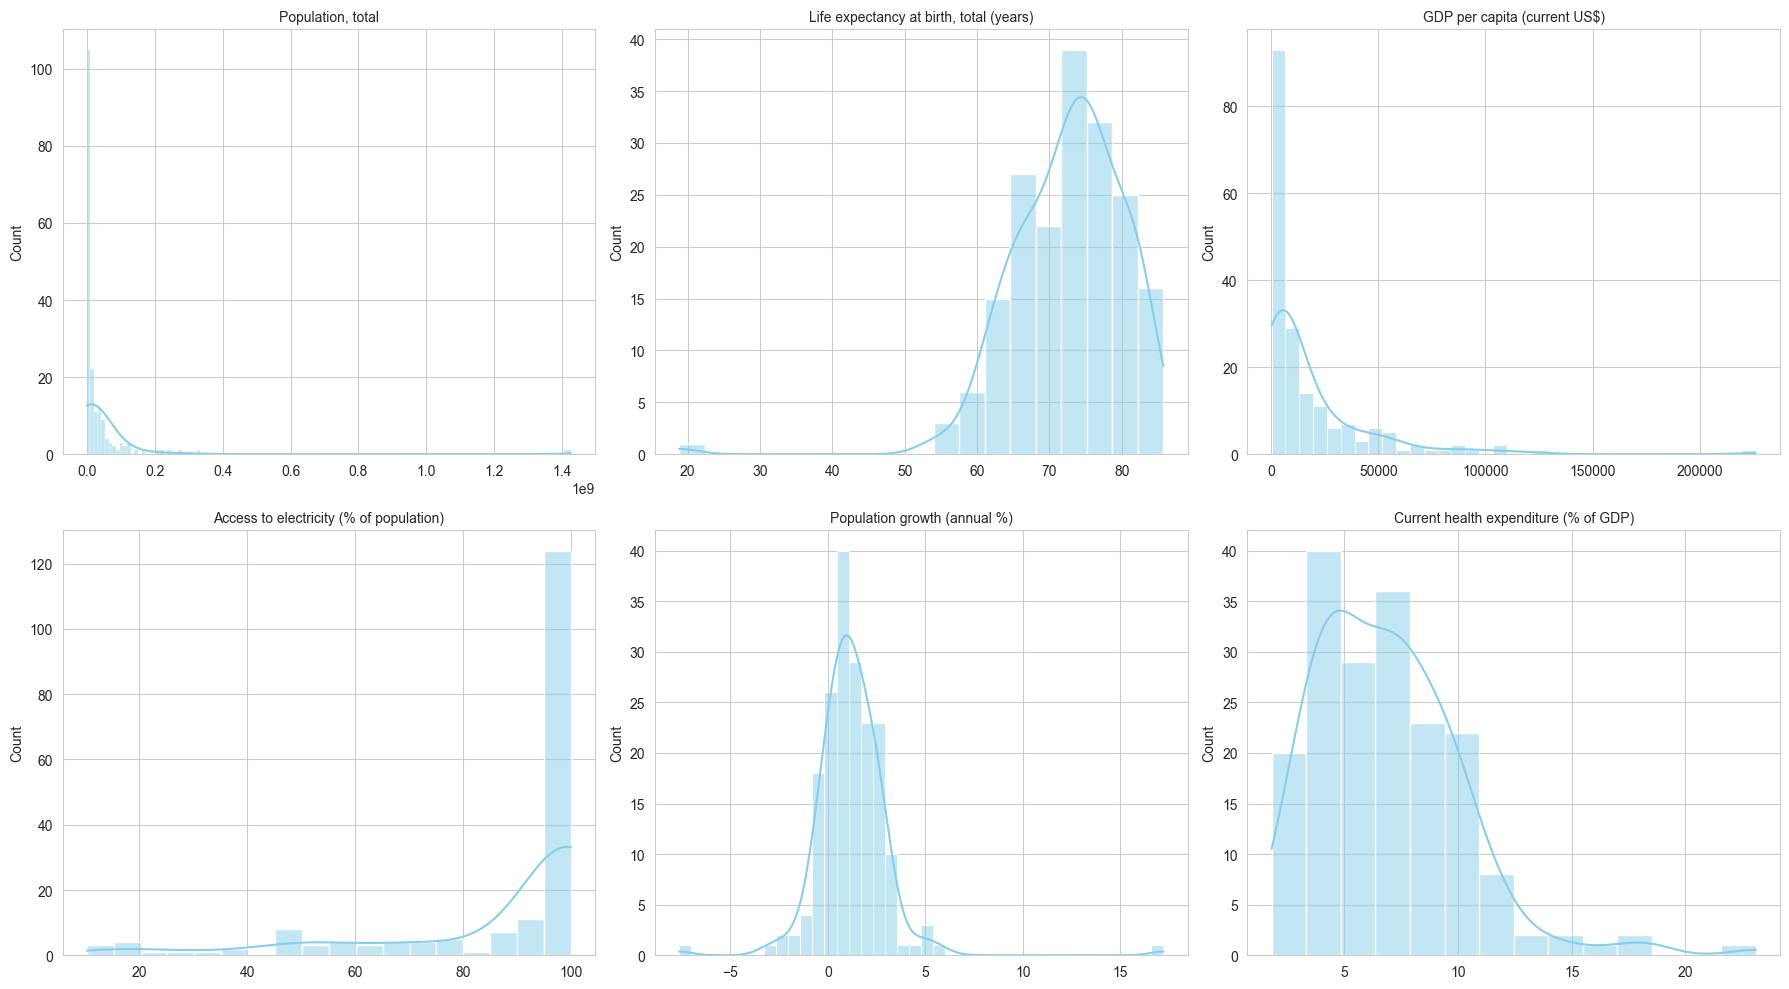

In [14]:
columns_to_plot = [
    'Population, total',
    'Life expectancy at birth, total (years)',
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Population growth (annual %)',
    'Current health expenditure (% of GDP)'
]

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(data_2022[col].dropna(), kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel('') 

plt.tight_layout()
plt.show()

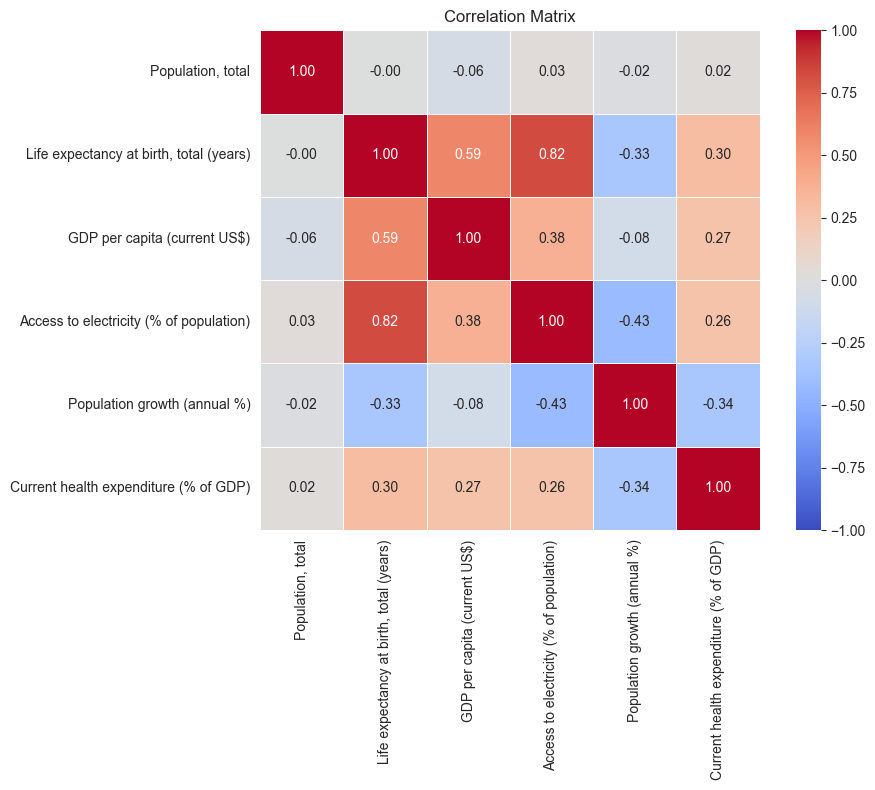

In [ ]:
correlation_matrix = data[columns_to_plot].corr()
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix, 
    annot=True,      
    fmt=".2f",        
    cmap='coolwarm',   
    vmin=-1, vmax=1,   
    linewidths=0.5,    
    square=True         
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

We can se that our target value is correlated most with acces to electricity which is surprising. It is also correlated much to GDP per capita. 

Modelling

In [116]:
target_col = 'Life expectancy at birth, total (years)'
features_to_drop = ['Country Name', 'Country Code','empty_values',target_col]

X = data.drop(columns=features_to_drop)
y = data[target_col]


X_train = X[X['Year'] < 2019]
y_train = y[X['Year'] < 2019]

X_test = X[X['Year'] >= 2019]
y_test = y[X['Year'] >= 2019]


print(f"Training size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Training size: (3838, 6)
Test size: (808, 6)


In [118]:
X_train = X_train.fillna(0)

C:\Users\Maksym\AppData\Local\Temp\ipykernel_11192\2585846990.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.fillna(0)


In [45]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [119]:
results = []

print(f"{'Model':<20} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 46)

for name, model in models.items():

    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    
    print(f"{name:<20} | {rmse:<10.4f} | {r2:<10.4f}")

Model                | RMSE       | R2 Score  
----------------------------------------------
Linear Regression    | 4.4578     | 0.6561    
Decision Tree        | 3.3760     | 0.8028    
Random Forest        | 2.9168     | 0.8528    


Best model turned out to be Random Forest, let's train one more time but with grid of parameters to find best ones

In [94]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),                
    ('regressor', RandomForestRegressor(random_state=42))
])


param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=3,              
    n_jobs=-1,         
    scoring='r2',        
    verbose=1          
)

grid_search.fit(X_train, y_train)

print("\n--- Best parameters ---")
print(grid_search.best_params_)

print("\n--- Best score (R2) ---")
print(f"{grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Test set results ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

--- Best parameters ---
{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}

--- Best score (R2) ---
0.8114

--- Test set results ---
RMSE: 3.1447
R2 Score: 0.8289


We will train base model with only one training feature, the most correlated one with target value to see how 1-dim regression is doing.

In [50]:
X_train = X_train[["Access to electricity (% of population)"]]
X_test = X_test[["Access to electricity (% of population)"]]

grid_search.fit(X_train, y_train)

print("\n--- Best parameters ---")
print(grid_search.best_params_)

print("\n--- Best score (R2) ---")
print(f"{grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Test set results ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

--- Best parameters ---
{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}

--- Best score (R2) ---
0.7352

--- Test set results ---
RMSE: 4.9766
R2 Score: 0.5715


1-dim Regression is much worse than using whole set.

To summarize our final model used with cv has RMSE = 3.1449 which is fine, because the target value mean is equal to 69.83, so relative error is 4.5%

We saw on chart that there is strong linearity between log of gdp per capita and life expectancy, so let's model on log of gdp per capita

In [102]:
data['GDP per capita (current US$)'] = pd.to_numeric(
    data['GDP per capita (current US$)'], 
    errors='coerce'
)
data['GDP per capita (current US$)'] = np.log(data['GDP per capita (current US$)'])

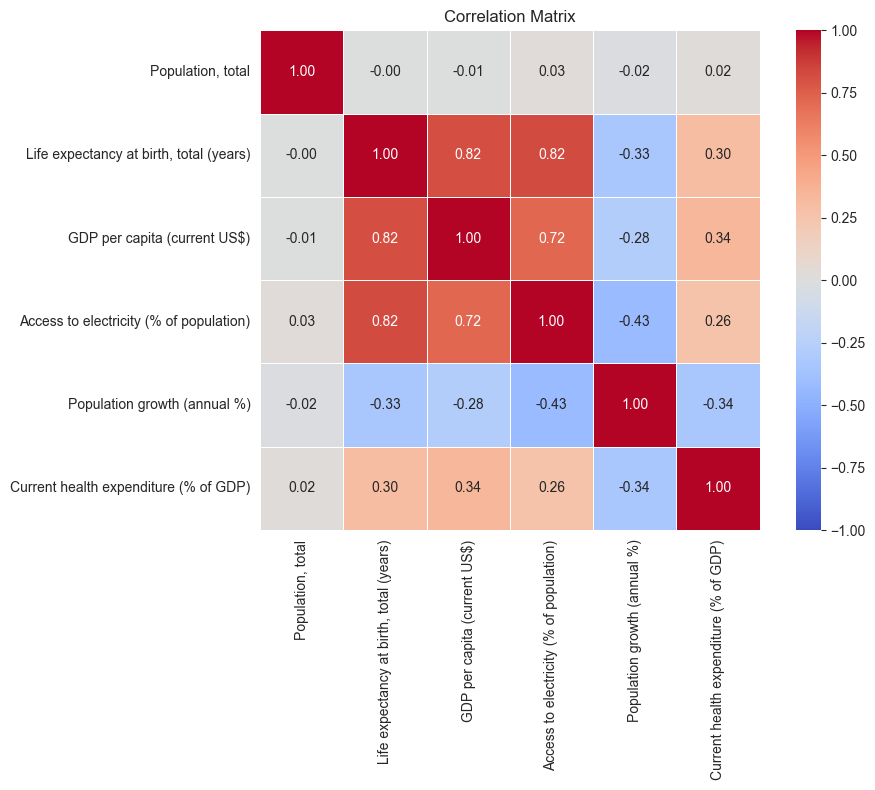

In [103]:
correlation_matrix = data[columns_to_plot].corr()
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix, 
    annot=True,      
    fmt=".2f",        
    cmap='coolwarm',   
    vmin=-1, vmax=1,   
    linewidths=0.5,    
    square=True         
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Correlation is now higher between life expectancy and GDP per capita

In [105]:
target_col = 'Life expectancy at birth, total (years)'
features_to_drop = ['Country Name', 'Country Code','empty_values',target_col]

X = data.drop(columns=features_to_drop)
y = data[target_col]


X_train = X[X['Year'] < 2019]
y_train = y[X['Year'] < 2019]

X_test = X[X['Year'] >= 2019]
y_test = y[X['Year'] >= 2019]


print(f"Training size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
X_train = X_train.fillna(0)
results = []

print(f"{'Model':<20} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 46)

for name, model in models.items():

    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    
    print(f"{name:<20} | {rmse:<10.4f} | {r2:<10.4f}")

Training size: (3838, 6)
Test size: (808, 6)
Model                | RMSE       | R2 Score  
----------------------------------------------
Linear Regression    | 4.1290     | 0.7050    
Decision Tree        | 3.3760     | 0.8028    


C:\Users\Maksym\AppData\Local\Temp\ipykernel_11192\646132428.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.fillna(0)


Random Forest        | 2.9165     | 0.8528    


We can see that linear regression model did better